In [1]:
import copy
import sys
sys.path.append('..')

import cobra
import escher
import pandas as pd
import timeit

import matplotlib.pyplot as plt
import numpy as np

import cameo

plt.style.use("bmh")

from cameo import fba
from cameo import pfba

import numpy.lib.recfunctions as rfn


from excel_read import read_excel
from matplotlib import cm
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.precision = 10

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def highlight_min(s):
    '''
    highlight the minimum in a Series ligthblue.
    '''
    is_min = s == s.min()
    return ['background-color: lightblue' if v else '' for v in is_min]

def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, green otherwise.
    """
    color = 'lightcoral' if val < 0 else 'lightgreen'
    return 'background-color: %s' % color

np.set_printoptions(precision=15, suppress=True)

In [2]:
%time m = cameo.load_model("../FBA_Dmel.xml") 

composition = pd.read_excel("../Experiments/Exp_1-3_HD_HD-sucrose_HD-EAA/Exp_1-3.xlsx",
                sheetname=None,header=None)


water = round(804.49 * 0.9982067, 3) # ml * g/ml

#ingredients [in g]
ing = np.array([
       (20,    "Agar"),
       (3.147,"Glacial acetic acid"),
       (3,    "KH2PO4"),
       (1,    "NaHCO3"),
       ((17.12*1), "Sucrose"),
       ((1.16*1), "Isoleucine"),
       ((1.64*1), "Leucine"),
       ((0.84), "Tyrosine"),
       (0.25, "CaCl2"),
       (0.0025,"CuSO4"),
       (0.025,"FeSO4"),
       (0.25 ,"MgSO4"),
       (0.0001,"MnCl2"),
       (0.025,"ZnSO4"),
    
       (0.3,  "Cholesterol"),
       (water,"Water"),
       
       ((0.92*1), "Arginine"),
       ((0.68*1), "Histidine"),
       ((1.74*1), "Lysine"),
       ((0.33*1), "Methionine"),
       ((1.42*1), "Phenylalanine"),
       ((1.295*1), "Threonine"),
       ((1.34*1),  "Tryptophan"),
       ((.44*1), "Valine"),
    
       ((1.59*1), "Alanine"),
       ((.84*1), "Asparagine"),
       ((.84*1), "Aspartic Acid"),
       ((0.264*1),"Cysteine"),
       ((1.82*1), "Glutamine"),
       ((1.08*1), "Glycine"),
       ((0.56*1), "Proline"),
       ((.76*1), "Serine"),
       ((1.821*1),"Glutamate"),
    
       (0.0021,"Thiamine"),
       (0.0011,"Riboflavin"),
       (0.0126,"Nicotinic acid"),
       (0.0163,"Ca pantothenate"),
       (0.0026,"pyridoxine"),
       (0.0002,"biotine"),
       (0.0005,"Sodium folate"),
    
       (0.05,  "Choline chloride"),
       (0.005, "Myo-inositol"),
       (0.065, "Inosine"),
       (0.06,  "Uridine"),
    
       (5.958, "Propionic acid"),
       (1.5,"Nipagin")], 
    dtype=[('mass[g]', 'f4'), ('names', 'S20')])

Academic license - for non-commercial use only
Wall time: 224 ms


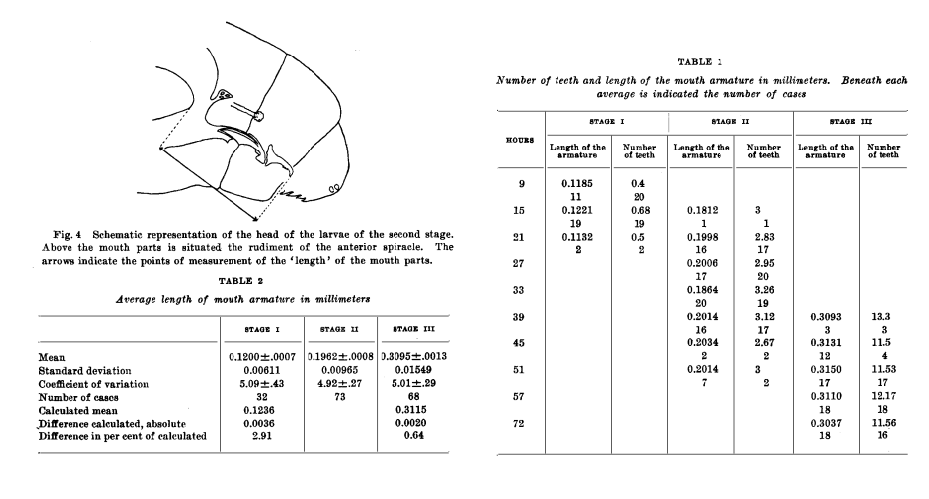

Mean width (96 h - 168 h) | Larval diameter:  0.4726629411918457 mm
Larva radius:  0.23633147059592285 mm
Mouth radius:  0.11816573529796143 mm
Length of mouth:  0.25285 mm
Mouth volume:  0.011091644823856267 mm³
Intake of a larva: 0.0642167635017287 g/h


In [3]:
""" 
Dietary intake calc. by the volume of the mouth of a larva with the length of the mouth [1] and
the sclerite reactions per minute [2] in g/h. 
Diameter of the whole larva from experiment 01-03 (Exp_1-3.xlsx) by calc. the mean of the width from timepoints 168 h and 96 h.

[1] ALPATOV, W. W. Growth and variation of the larvae of Drosophila melanogaster.
    Journal of Experimental Zoology Part A: Ecological Genetics and Physiology,
    1929, 52. Jg., Nr. 3, S. 407-437.
[2] FELLOWES, M. D. E.; KRAAIJEVELD, A. R.; GODFRAY, H. C. J. 
    Association between feeding rate and parasitoid resistance in Drosophila melanogaster.
    Evolution, 1999, 53. Jg., Nr. 4, S. 1302-1305. 
"""

plt.figure(figsize=(16,12))
img=mpimg.imread('mouth.png') #[1]
imgplot = plt.imshow(img)
plt.grid(b=False, which="both")
plt.axis("off")
plt.show()

width_list = composition["width"].fillna("")

print "Mean width (96 h - 168 h) | Larval diameter: ", np.mean([width_list[1][82],width_list[3][82]]), "mm"
r_l= np.mean([width_list[1][82],width_list[3][82]])/2 # ~0.23mm radius of the whole larva
print "Larva radius: ",r_l, "mm"
r = r_l/2
print "Mouth radius: ",r, "mm"
h = np.mean([0.1962,0.3095]) #mm ; ~mean of stage II and stage III
print "Length of mouth: ", h, "mm"

##############################
### calc. of intake in g/h ###
##############################

vol_mouth = np.pi * r**2 * h # each in mm
print "Mouth volume: ", vol_mouth , u"mm\u00b3"
food = sum(ing["mass[g]"])*10**(-6) # g/l in g/µl
intake = vol_mouth * 60 * 110 * food# mm³ * min/h * /min * g/µl = mm³/h * g/µl = µl/h * g/µl = g/h
print "Intake of a larva:", intake,"g/h"

In [4]:
""" 

Dry weight based on measurements (Exp_1-3.xlsx by Lisa Jehrke) .
Diff. of two time points on holidic growth medium.

"""
dry_w_list = composition["dry weight"].fillna("")

mass = np.array([dry_w_list[1][13],dry_w_list[2][13],dry_w_list[3][13]])

mass_sd = np.array([dry_w_list[1][14],dry_w_list[2][14],dry_w_list[3][14]])


dry_w = round(mass[2] - mass[0],4)*10**(-3)
dry_w_sd = round(mass_sd[2] - mass_sd[0],4)*10**(-3)
print "Dry weight of a larva on holidic growth media: %sg +- %sg" % (dry_w,dry_w_sd)

Dry weight of a larva on holidic growth media: 0.0002019g +- 3.31e-05g


In [5]:
""" 

Calc. of the uptake flux rate based on the Holidic Diet[3] and approximation. Dry weight is ~20% [4] (Not important anymore.)

[3] Piper MD, Blanc E, Leitão-Gonçalves R, et al. A holidic medium for Drosophila melanogaster.
    Nature methods. 2014;11(1):10.1038/nmeth.2731. doi:10.1038/nmeth.2731. 
[4] Bakker, K. 1959 Feeding period, growth, and pupation in larvae of Drosophila melanogaster.
    Ent exp. et appl., 2: 171-186. 
    
"""


flux_tab_all = []

x = np.round(np.arange(0,.201,.001),3)

for i in x:
# ingredients as amount of overall food
    ing_perc = np.empty(ing.shape,dtype=[('values', 'f4'), ('names', 'S20')])
    ing_perc["names"] = ing["names"]
    ing_perc["values"] = np.round((ing["mass[g]"])/sum((ing["mass[g]"])),8)#*100



    ing_g = np.empty(ing_perc.shape,dtype=[('mass per time[g/h]', 'f4'), ('names', 'S20')])
    ing_g["names"] = ing_perc["names"]
    ing_g["mass per time[g/h]"] = (ing_perc["values"]*(intake*i)) # multip. with intake per hour g/h, here correction term! 



    #from ChEBI (http://www.ebi.ac.uk/chebi/init.do) and Sigma# g/mol
    mol_tab = np.array([342.29650, 131.17296, 131.17296, 181.18858,  18.01530, 174.20100, 155.15468, 146.18764, 149.21238,
                              165.18918, 119.11920, 204.22526, 117.14638, 89.09322, 132.11800, 133.10270, 121.15800, 146.14458,
                              75.06664, 115.13050, 105.09262, 147.12930, 376.36390]) # g/mol = mg/mmol #Sucrose, Isoleucine, Leucine, Tyrosine, Cholesterol, 
                                                                                                #Water, Arginine, Histidine, Lysine, Methionine, Phenylalanine,
                                                                                                #Threonine, Tryptophan, Valine, Alanine, Asparagine, 
                                                                                                #Aspartic Acid, Cysteine, Glutamine, 
                                                                                                #Glycine, Proline, Serine, Glutamate, Riboflavin
                
    mol_tab_all = np.array([1,60.05,136.09,84.01, 342.29650, 131.17296, 131.17296, 181.18858,147.01,249.7,278.01,120.37,125.84, 287.56,386.65   , 18.01530, 174.20100, 155.15468, 146.18764, 149.21238,
                              165.18918, 119.11920, 204.22526, 117.14638, 89.09322, 132.11800, 133.10270, 121.15800, 146.14458,
                              75.06664, 115.13050, 105.09262, 147.12930,337.27 ,376.36390, 123.11, 238.27, 205.64, 244.31, 441.40, 139.62, 180.16, 268.23, 244.20, 74.08, 152.15]) # Agar has no value

    
    dict1 = zip((mol_tab_all*10**(-3)),ing_perc["names"]) # g/mmol # match metabolites with molar mass values

    mol_tab = np.sort(np.array(dict1, dtype=[('values[g/mmol]', 'f4'),('names', 'S20')]), order= "names")
    ing_g_selected = np.sort((ing_g[np.isin(ing_g["names"],mol_tab["names"])]),order="names")

    uptake_mol = np.empty(mol_tab.shape,dtype=[('values[mmol/h]', 'f4'), ('names', 'S20')])
    uptake_mol["names"] = mol_tab["names"]
    uptake_mol["values[mmol/h]"] = (ing_g_selected["mass per time[g/h]"]/mol_tab["values[g/mmol]"])

    flux_tab = np.empty(uptake_mol.shape,dtype=[('values[mmol/(g*h)]', 'f4'), ('names', 'S20')])
    flux_tab["names"] = mol_tab["names"]
    flux_tab['values[mmol/(g*h)]'] = (uptake_mol["values[mmol/h]"]/dry_w) # / dry weight (g) #.000306

    flux_tab_all += flux_tab["values[mmol/(g*h)]"].astype('Float64').tolist()
flux_tab_all = np.array(np.round(flux_tab_all,8)).reshape((len(x)),46)

uptake = pd.DataFrame(flux_tab_all.T,columns=x,index=flux_tab["names"])
#ing_perc

F:\FlySilico_fin\envs\default\lib\site-packages\ipykernel_launcher.py:58: DeprecationWarning:

Numeric-style type codes are deprecated and will result in an error in the future.



In [6]:
#uptake_list = pd.DataFrame(uptake[0.122])
#uptake_list
#uptake_list.to_csv('uptake_2xEAA.csv', index=True)

In [7]:
match_list = {"Alanine" : "EX_ala(e)",
              "Arginine" : "EX_arg(e)",
              'Asparagine' : "EX_asn(e)",
              'Aspartic Acid' : "EX_asp(e)",
              'Ca pantothenate' : "None",
              'CaCl2' : "None",
              'Cholesterol' : 'EX_clr(e)',
              'Choline chloride' : 'EX_choline(e)',
              'CuSO4' : "None",
              'Cysteine' : 'EX_cys(e)',
              'FeSO4' : "None",
              'Glacial acetic acid' : "None",
              'Glutamate' : 'EX_glu-L(e)', 
              'Glutamine' : 'EX_gln-L(e)',
              'Glycine' : 'EX_gly(e)', 
              'Histidine' : 'EX_his(e)',
              'Inosine' : 'EX_i(e)',
              'Isoleucine' : 'EX_ile(e)',
              'KH2PO4' : "None",
              'Leucine' : 'EX_leu(e)',
              'Lysine' : 'EX_lys(e)',
              'Methionine' : 'EX_met(e)',
              'MgSO4' : "None",
              'MnCl2' : "None",
              'Myo-inositol' : 'EX_ins(e)',
              'NaHCO3' : "None",
              'Nicotinic acid' : "None",
              'Nipagin' : "None",
              'Phenylalanine' : 'EX_phe(e)',
              'Proline' : 'EX_pro(e)',
              'Propionic acid' : "None",
              'Riboflavin' : 'EX_RIBFLV(e)',
              'Serine' : 'EX_ser(e)',
              'Sodium folate' : "None",
              'Sucrose' : 'EX_sucr',
              'Thiamine' : "None",
              'Threonine' : 'EX_thr(e)',
              'Tryptophan' : 'EX_trp(e)',
              'Tyrosine' : 'EX_tyr(e)',
              'Uridine' : 'EX_urd(e)',
              'Valine' : 'EX_val(e)',
              'Water' : "None",
              'ZnSO4' : "None",
              'biotine' : "None",
              'pyridoxine' : "None"}

In [8]:
growth = []
growth_ll = []

m_loopless = copy.deepcopy(m) #copy the model to prepare a loopless model
print "erstelle loopless model"
cobra.flux_analysis.add_loopless(m_loopless) # convert model in loopless model

rnd = 0 #only counter
rnd2 = 0 #only counter
for corr_term in x:
    rnd2 += 1 
    if rnd2 > rnd: #counter for progress
        print corr_term
        rnd += 50
    for z in match_list:
        if match_list[z] != "None":
            
            m.reactions.get_by_id(match_list[z]).lower_bound = -uptake.loc[z][corr_term] # changing lb
            m_loopless.reactions.get_by_id(match_list[z]).lower_bound = -uptake.loc[z][corr_term] # changing lb
       
    try: # to avoid infeasable solutions
        fba_result = fba(m) #fba result of the model
        growth += [fba_result.objective_value]
    except: # if infeasable, add growth rate of 0
        growth += [0]
        
    try: # to avoid infeasable solutions
        fba_result_loopless = fba(m_loopless) #fba result of the loopless model
        growth_ll += [fba_result_loopless.objective_value]
    except: # if infeasable, add growth rate of 0
        growth_ll += [0]
growth = np.array(growth)
growth_ll = np.array(growth_ll)
    


Read LP format model from file c:\users\jurgen\appdata\local\temp\tmpelvz7l.lp
Reading time = 0.01 seconds
: 293 rows, 726 columns, 2516 nonzeros
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Parameter Method unchanged
   Value: 0  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
erstelle loopless model
0.0
0.05
0.1
0.15
0.2


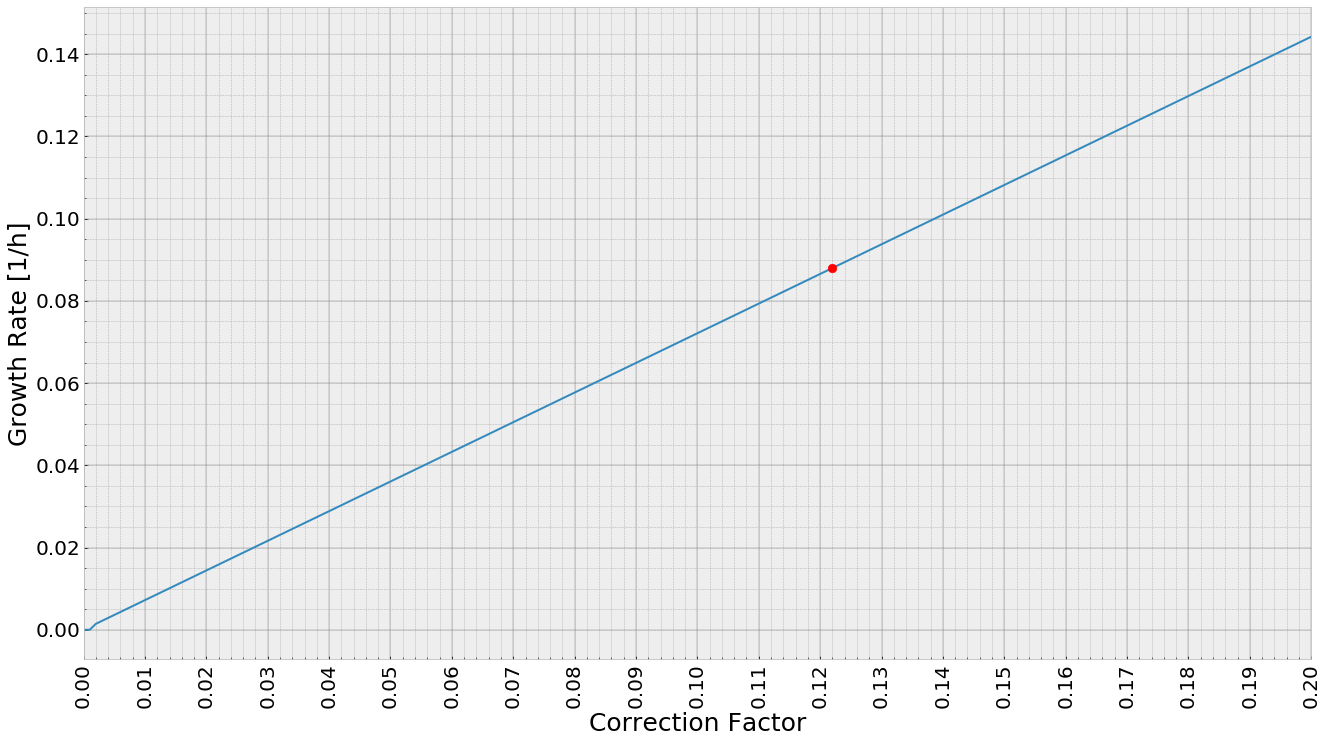

In [9]:

fig,ax = plt.subplots(figsize=(22,12))
plt.plot(x,growth_ll)
#plt.plot(x,growth,color="red",linestyle ="dashed")
plt.xlabel("Correction Factor", size= 25)
plt.ylabel("Growth Rate [1/h]", size= 25)
plt.xticks(x[::10],rotation= 90, size= 20)
plt.yticks(np.arange(0,max(growth)+.04,.02), size= 20)

plt.grid(color='black', linestyle='-', linewidth=.2)

minor_ticks = np.arange(0,max(growth)+.04,0.005)
minor_ticks_x = np.arange(0,x[-1]+.002,0.002)
ax.set_yticks(minor_ticks, minor=True)
ax.set_xticks(minor_ticks_x, minor=True)
ax.grid(b=True, which="minor")

plt.xlim(0,max(x))


gll_ind = np.argwhere( growth_ll > .0878 )[0]
plt.scatter(float(".%s" % gll_ind[0]),growth_ll[gll_ind], color="red", marker=".", s=300, zorder=3)
gll_ind[0]
plt.savefig('correction_factor.png', bbox_inches='tight')

In [10]:
print 0.08822 - growth_ll[123]
print 0.08822 - growth_ll[122]
print 0.08822 - growth_ll[121]
print 0.08822 - growth_ll[120]
growth_ll[122]

-0.0004959114807129988
0.00022536431930744727
0.0009466311415679274
0.0016678992463655395


0.08799463568069256

In [11]:
# experimental growth rate

print "HD"
print (((.2338)-(.0318))/72)/(.0318)


HD
0.0882250174703
